# Jupyter Canvas Widget - Rail Editor

From - https://github.com/Who8MyLunch/Jupyter_Canvas_Widget/blob/master/notebooks/example%20mouse%20events.ipynb
Follow his instructions to do a local dev install and enable the widget.

## You need to run all cells before trying to edit the rails!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import image_attendant as imat
import ipywidgets
import IPython
import jpy_canvas
import numpy as np
from numpy import array
import time
from collections import deque
from matplotlib import pyplot as plt
import io
from PIL import Image

In [3]:
from ipywidgets import IntSlider, link, VBox

In [4]:
import flatland.core.env
from flatland.envs.rail_env import RailEnv, random_rail_generator
from flatland.core.transitions import RailEnvTransitions
from flatland.core.env_observation_builder import TreeObsForRailEnv
import flatland.utils.rendertools as rt

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
oEnv = RailEnv(width=10,
              height=10,
              rail_generator=random_rail_generator(cell_type_relative_proportion=[1,1] + [0.5] * 6),
              number_of_agents=0,
              obs_builder_object=TreeObsForRailEnv(max_depth=2))
obs = oEnv.reset()

oRT = rt.RenderTool(oEnv)

In [7]:
sfEnv = "../flatland/env-data/tests/test1.npy"
oEnv.rail.load_transition_map(sfEnv)

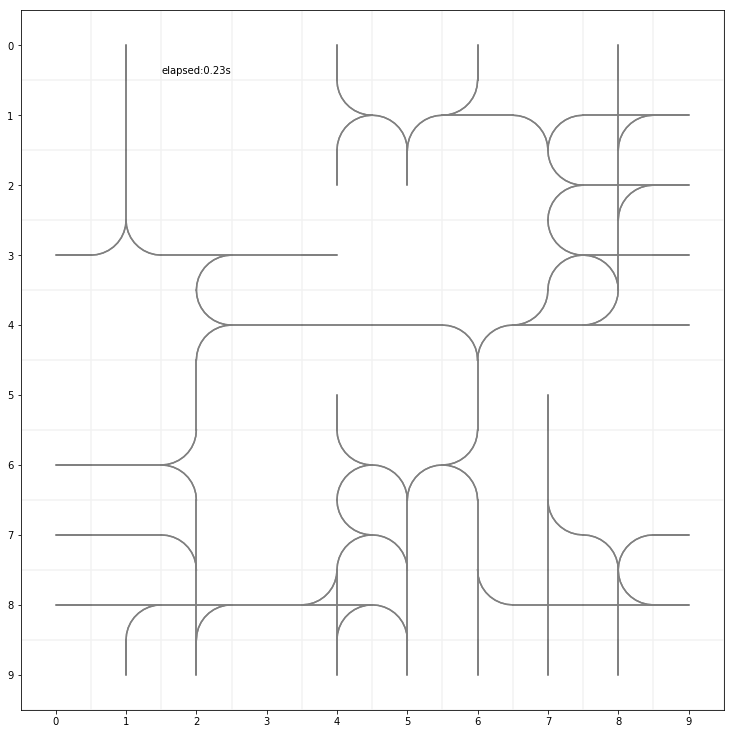

In [8]:
oFig = plt.figure(figsize=(10,10))
oRT.renderEnv(spacing=False, arrows=False, sRailColor="gray", show=False)
img = oRT.getImage()
#plt.clf()
pass

In [9]:
# This API call is misleading - it doesn't update the env's transition map.
oEnv.rail.set_transition((1,1,2), 1, True)

In [10]:
oEnv.rail.get_transition((1,1,2), 1)

0

In [11]:
bin(oEnv.rail.grid[1,1])

'0b1000000000100000'

In [12]:
cell_id = (1,1,2)
iDir = 1
iValCell = oEnv.rail.transitions.set_transition(oEnv.rail.grid[cell_id[0]][cell_id[1]], cell_id[2], iDir, True)
bin(iValCell)

'0b1000000001100000'

In [13]:
oEnv.rail.grid[cell_id[0]][cell_id[1]] = iValCell

In [14]:
bin(oEnv.rail.grid[1,1])

'0b1000000001100000'

In [15]:
#image = imat.read("../Jupyter_Canvas_Widget/notebooks/images/mini_1.jpg")
image = img
image_b = imat.rebin(image, 0.25)  

H,W = image.shape[:2]

L = 20
L2 = L*2 + 1

In [16]:
wid_img = jpy_canvas.Canvas(image)
wid_sub = jpy_canvas.Canvas(image_b)
wid_sub.width=300
wid_sub.layout.border='black'

wid_img.width = W 
wid_img.height = H 

# wid_sub.width = L2*3
# wid_sub.height = L2*3

# guessing these:
xyBase = array([20,20])
nPixCell = 70

#wid_box = ipywidgets.HBox([wid_img, wid_sub])

### Edit the map below here by dragging the mouse to create transitions

In [17]:
#wid_box
wid_img

Canvas()

[2 2] [0 1]
[0 1] [1 1]
iTrans:  2
[1 1] [1 2]
iTrans:  1
iTransLast 2
Set RCD: [1 1] 2 to:  1


<Figure size 720x720 with 0 Axes>

[1 2] [1 3]
iTrans:  1
iTransLast 1
Set RCD: [1 2] 1 to:  1


<Figure size 720x720 with 0 Axes>

[1 3] [2 3]
iTrans:  2
iTransLast 1
Set RCD: [1 3] 1 to:  2


<Figure size 720x720 with 0 Axes>

[2 3] [2 2]
iTrans:  3
iTransLast 2
Set RCD: [2 3] 2 to:  3


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 3
Set RCD: [2 2] 3 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [2 2]
iTrans:  1
iTransLast 3
Set RCD: [2 1] 3 to:  1


<Figure size 720x720 with 0 Axes>

[2 2] [2 3]
iTrans:  1
iTransLast 1
Set RCD: [2 2] 1 to:  1


<Figure size 720x720 with 0 Axes>

[2 3] [2 2]
iTrans:  3
iTransLast 1
Set RCD: [2 3] 1 to:  3


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 3
Set RCD: [2 2] 3 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [2 2]
iTrans:  1
iTransLast 3
Set RCD: [2 1] 3 to:  1


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 1
Set RCD: [2 2] 1 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [2 2]
iTrans:  1
iTransLast 3
Set RCD: [2 1] 3 to:  1


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 1
Set RCD: [2 2] 1 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [2 2]
iTrans:  1
iTransLast 3
Set RCD: [2 1] 3 to:  1


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 1
Set RCD: [2 2] 1 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [2 2]
iTrans:  1
iTransLast 3
Set RCD: [2 1] 3 to:  1


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 1
Set RCD: [2 2] 1 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [2 2]
iTrans:  1
iTransLast 3
Set RCD: [2 1] 3 to:  1


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 1
Set RCD: [2 2] 1 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [2 2]
iTrans:  1
iTransLast 3
Set RCD: [2 1] 3 to:  1


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 1
Set RCD: [2 2] 1 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [2 2]
iTrans:  1
iTransLast 3
Set RCD: [2 1] 3 to:  1


<Figure size 720x720 with 0 Axes>

[2 2] [2 1]
iTrans:  3
iTransLast 1
Set RCD: [2 2] 1 to:  3


<Figure size 720x720 with 0 Axes>

[2 1] [3 1]
iTrans:  2
iTransLast 3
Set RCD: [2 1] 3 to:  2


<Figure size 720x720 with 0 Axes>

[3 1] [1 2]
[1 2] [1 1]
iTrans:  3
iTransLast 2
Set RCD: [1 2] 2 to:  3


<Figure size 720x720 with 0 Axes>

In [18]:
lEvDraw = deque()

rcLast = array([-1,-1])
iTransLast = -1

gRCTrans = array([[-1,0], [0,1], [1,0], [0,-1]]) # NESW in RC
rcTrans = array([1,1])
iTrans = np.argwhere(np.all(gRCTrans - rcTrans == 0, axis=1))
len(iTrans)


0

In [19]:
def work_function(wid, event):
    """Mouse motion event handler
    """
    global rcLast, iTransLast
    
    i = event['canvasX']    
    i0 = i-L
    i1 = i+L+1

    j = event['canvasY']
    j0 = j-L
    j1 = j+L+1

    if i0 < 0:
        i0 = 0
        
    if j0 < 0:
        j0 = 0
        
    #crop = wid.data[j0:j1, i0:i1]
    #print(event)
    #print(i0,i1,j0,j1)
    #print(wid.data[i,j])
    #print(crop.shape)
    
    if False:
        with wid_sub.hold_sync():
            wid_sub.data = crop
            wid_sub.width = crop.shape[1]*5
            wid_sub.height = crop.shape[0]*5

    
    if event["buttons"] > 0:
        if False:
            width, height = wid.data.shape[:2]
            with wid.hold_sync():

                if i>10 and i<width and j> 10 and j < height:
                    writableData = np.copy(wid.data)
                    writableData[j-5:j+5, i-5:i+5, :] = 255
                    wid.data = writableData
        else:
            lEvDraw.append((time.time(), i,j))
    
    if len(lEvDraw) > 0:
        tNow = time.time()
        if tNow - lEvDraw[0][0] > 0.1: # wait before trying to draw
            height, width = wid.data.shape[:2]
            writableData = np.copy(wid.data)
            bRedrawn = False
            with wid.hold_sync():
                #rcLast = array([-1,-1])
                while len(lEvDraw) > 0:
                    t, i, j = lEvDraw.popleft()
                    #print("tij:", t,i,j)
                    if i>10 and i<width and j> 10 and j < height:
                        writableData[j-2:j+2, i-2:i+2, :] = 0
                    
                    rcCell = ((array([j,i]) - xyBase) / nPixCell).astype(int)
                    
                    if (not np.array_equal(rcLast, array([-1,-1]))) and not np.array_equal(rcLast, rcCell):
                        print (rcLast, rcCell)  
                        rcTrans = rcCell - rcLast
                        iTrans = np.argwhere(np.all(gRCTrans - rcTrans == 0, axis=1))
                        if len(iTrans) > 0:
                            iTrans = iTrans[0][0]
                            print("iTrans: ", iTrans)
                            if iTransLast >= 0:
                                print("iTransLast", iTransLast)
                                print("Set RCD:", rcLast, iTransLast, "to: ", iTrans )
                                #oEnv.rail.set_transition((*rcLast, iTransLast), iTrans, True) # does nothing
                                iValCell = oEnv.rail.transitions.set_transition(oEnv.rail.grid[rcLast[0], rcLast[1]], iTransLast, iTrans, True)
                                oEnv.rail.grid[rcLast[0], rcLast[1]] = iValCell
                                
                                oFig = plt.figure(figsize=(10,10))
                                oRT.renderEnv(spacing=False, arrows=False, sRailColor="gray", show=False)
                                img = oRT.getImage()
                                plt.clf()
                                wid.data = img
                                bRedrawn = True
                                
                                
                            iTransLast = iTrans
                    rcLast = rcCell
                
                if not bRedrawn:
                    wid.data = writableData
                #wid.width = W 
                #wid.height = H

In [20]:
wid_img.register_move(work_function)

### Junk below here

In [21]:
crop = wid_img.data[0:3, 0:3]
crop

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)

In [22]:
image2 = np.copy(image)
print(type(image2), image2.shape)

<class 'numpy.ndarray'> (720, 720, 3)


In [23]:
W,H


(720, 720)

In [24]:
array([2,3]).astype(int)

array([2, 3])

In [25]:
gA = np.zeros((5,5))
gA[2,2]= 1

rcLast = array([2,2])
gA[rcLast.T] 
#gA

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])